<a href="https://colab.research.google.com/github/rlagosb/taller_eiv/blob/main/2_Ejercicio_Normalizaci%C3%B3n_(R).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ejercicio: Normalización de datos

En este ejercicio vamos normalizar los datos de la demanda y la oferta de consultas de especialidad médica en el Servicio de Salud Metropolitano Sur Oriente en 2021. Vamos a  organizar los datos de manera eficiente para minimizar la redundancia y mejorar la integridad de los datos. Para ello es necesario:

1. Identificar las entidades y relaciones en un diagrama E-R
1. Normalizar datos de Demanda (interconsultas)
1. Normalizar datos de Especialidades
3. Normalizar datos de Oferta (producción, programación)

## Modelo Entidad-Relación

Primero es necesario tener un esquema de qué describen los datos e identificar las tablas necesarias. En este ejercicio podemos identificar as entidades:

- Centro de salud
- Especialidad
- Demanda entrante (interconsultas nuevas)
- Demanda acumulada (lista de espera al inicio del periodo)
- Capacidad (producción histórica)
- Programación


# Configurar área de trabajo

In [ ]:
#borrar objetos previos
rm(list=ls())
#borrar figuras (si hay)
while(!dev.cur())dev.off()
cat("\014")

# Para manipulación de bases de datos. Si no existe, la instalamos
if(!require(dplyr)){install.packages("dplyr")}
# Para importar/exportar bases de datos. Si no existe, la instalamos
if(!require(rio)){install.packages("rio")}
# Para exportar archivos en formato parquet
if(!require(arrow)){install.packages("arrow")}
if(!require(nanoparquet)){install.packages("nanoparquet")}

# Definir carpetas de trabajo
datos_originales <- 'https://github.com/rlagosb/taller_eiv/raw/refs/heads/main/data/'
datos_crudos <- 'https://github.com/rlagosb/taller_eiv/raw/refs/heads/main/datos_crudos/'
datos_normalizados <- './datos_normalizados/'

# Crear carpetas
if (!dir.exists(datos_crudos)){dir.create(datos_crudos, recursive = TRUE)}
if (!dir.exists(datos_normalizados)){dir.create(datos_normalizados, recursive = TRUE)}

Loading required package: rio

Loading required package: arrow


Attaching package: ‘arrow’


The following object is masked from ‘package:utils’:

    timestamp


Loading required package: nanoparquet


Attaching package: ‘nanoparquet’


The following objects are masked from ‘package:arrow’:

    read_parquet, write_parquet




In [ ]:
# cargar datos
sic =           rio::import(paste0(datos_crudos, 'sic_2021_SSMSO.parquet'))
programacion =  rio::import(paste0(datos_crudos, 'programacion_2021_SSMSO.parquet'))
produccion =    rio::import(paste0(datos_crudos, 'rem_A07_2021_SSMSO.parquet'))

# 1- Normalizar demanda (solicitudes de interconsulta)

In [ ]:
# Examinemos la fuente de los datos de demanda
# ¿Cuáles campos son redundantes o innecesarios para nuestro análisis?
glimpse(sic) #resumen de los datos
# Configurar semilla para reproducibilidad
set.seed(123)
sic[sample(nrow(sic),5),] #tomamos 5 observaciones al azar

Rows: 150,632
Columns: 9
$ FECHA_NAC           <dttm> 2010-11-22, 1987-12-17, 1988-09-07, 1964-07-14, 2…
$ SEXO                <dbl> 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,…
$ TIPO_PREST          <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,…
$ PRESTA_MIN          <chr> "07-064", "07-056", "07-058", "09-008", "09-008", …
$ PRESTA_EST          <chr> "NUTRIOLOGO PEDIATRICO", "CIRUGIA ABDOMINAL", "GIN…
$ F_ENTRADA           <dttm> 2021-01-04, 2021-01-04, 2021-01-04, 2021-01-04, 2…
$ ESTAB_ORIG          <dbl> 114101, 114312, 114101, 114101, 114304, 114103, 11…
$ ESTAB_DEST          <dbl> 114101, 114101, 114101, 114101, 114105, 114101, 11…
$ `__index_level_0__` <dbl> 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, …


FECHA_NAC           SEXO TIPO_PREST PRESTA_MIN
134058 1970-01-01 00:00:00 2    1          07-056    
124022 1970-01-01 00:00:00 1    1          07-010    
103065 1970-01-01 00:00:00 2    1          07-053    
124507 1970-01-01 00:00:00 1    1          07-030    
45404  1970-01-01 00:00:00 2    1          07-041    
       PRESTA_EST                  F_ENTRADA  ESTAB_ORIG ESTAB_DEST
134058 Cirugia Abdominal           2021-07-05 114103     114103    
124022 Cirugia Vascular Periferica 2021-03-19 114103     114103    
103065 TRAUMATOLOGIA ADULTO        2021-11-02 114301     200282    
124507 Medicina Interna            2021-09-16 114103     114103    
45404  Neurologia                  2021-01-21 114103     114103    
       __index_level_0__
134058 132601           
124022 122561           
103065 101557           
124507 123046           
45404   43074

In [ ]:
#selecciono las columnas a continuación
demanda = sic[,c('PRESTA_MIN','F_ENTRADA','ESTAB_DEST')]
#ver la selección resultante
demanda

PRESTA_MIN F_ENTRADA  ESTAB_DEST
1      07-064     2021-01-04 114101    
2      07-056     2021-01-04 114101    
3      07-058     2021-01-04 114101    
4      09-008     2021-01-04 114101    
5      09-008     2021-01-04 114105    
6      07-040     2021-01-05 114101    
7      07-002     2021-01-05 114101    
8      07-040     2021-01-06 114101    
9      07-012     2021-01-07 114101    
10     07-005     2021-01-07 114101    
11     07-040     2021-01-07 114101    
12     09-001     2021-01-07 114101    
13     09-008     2021-01-07 114101    
14     09-001     2021-01-07 114101    
15     07-046     2021-01-08 114101    
16     07-046     2021-01-08 114105    
17     07-003     2021-01-08 114101    
18     09-011     2021-01-08 114101    
19     09-001     2021-01-08 114101    
20     09-008     2021-01-08 114101    
21     09-001     2021-01-08 114101    
22     07-056     2021-01-11 114101    
23     07-003     2021-01-11 114101    
24     07-046     2021-01-11 114101    
25     09-001     2021-01-11 114101    
26     09-001     2021-01-11 114101    
27     07-012     2021-01-12 114101    
28     07-066     2021-01-12 114101    
29     07-014     2021-01-12 114101    
30     07-046     2021-01-12 114101    
⋮      ⋮          ⋮          ⋮         
150603 09-001     2021-11-17 114101    
150604 07-053     2021-12-15 114103    
150605 07-018     2021-12-15 114103    
150606 09-008     2021-09-10 114101    
150607 07-018     2021-12-31 114103    
150608 07-002     2021-12-30 114103    
150609 07-002     2021-11-23 114103    
150610 07-018     2021-08-24 114103    
150611 07-012     2021-12-28 114105    
150612 07-018     2021-11-11 114103    
150613 07-018     2021-12-30 114103    
150614 07-002     2021-08-16 114103    
150615 07-002     2021-12-28 114103    
150616 07-018     2021-09-29 114103    
150617 07-002     2021-11-02 114103    
150618 07-018     2021-12-09 114103    
150619 07-018     2021-12-09 114103    
150620 07-018     2021-12-24 114103    
150621 07-018     2021-12-20 114103    
150622 07-002     2021-08-24 114103    
150623 07-018     2021-12-07 114103    
150624 07-046     2021-12-28 114105    
150625 09-001     2021-11-10 114101    
150626 07-018     2021-12-15 114103    
150627 07-003     2021-12-13 114101    
150628 09-001     2021-09-07 114101    
150629 07-030     2021-12-21 114101    
150630 07-030     2021-10-29 114101    
150631 07-030     2021-11-25 114101    
150632 07-049     2021-06-17 114105

In [ ]:
# Usaremos sólo el mes y año y botaremos la fecha exacta de la interconsulta
  #primero definimos la columna año extrayéndola de la columna fecha entrada (F_ENTRADA)
  demanda$Año <- format(as.Date(demanda$F_ENTRADA), "%Y")
  #luego definimos la columna mes extrayéndola de la columna fecha entrada (F_ENTRADA)
  demanda$Mes <- format(as.Date(demanda$F_ENTRADA), "%m")
  #eliminamos la columna F_ENTRADA (fecha original) para reducir la información innecesaria
  demanda$F_ENTRADA <- NULL

In [ ]:
# Contar valores y reiniciar el índice
demanda <-
demanda %>%
  #contar observaciones
  dplyr::count(PRESTA_MIN, ESTAB_DEST, Año, Mes) %>%
  #renombrar las variables
  dplyr::rename(Interconsultas  = n,
                Especialidad    = PRESTA_MIN,
                Centro_destino  = ESTAB_DEST)

#visión preliminar de los datos
dplyr::glimpse(demanda)
#resumen de los datos
summary(demanda)
#muestra aleatoria de 5 observaciones
set.seed(123)
print(demanda[sample(nrow(demanda), 5), ])

Rows: 2,149
Columns: 5
$ Especialidad   <chr> "07-002", "07-002", "07-002", "07-002", "07-002", "07-0…
$ Centro_destino <dbl> 114101, 114103, 114103, 114103, 114103, 114103, 114103,…
$ Año            <chr> "2021", "2021", "2021", "2021", "2021", "2021", "2021",…
$ Mes            <chr> "01", "01", "02", "03", "04", "05", "06", "07", "08", "…
$ Interconsultas <int> 2, 41, 30, 44, 39, 58, 59, 52, 69, 74, 62, 49, 28, 37, …


 Especialidad       Centro_destino       Año                Mes           
 Length:2149        Min.   :114101   Length:2149        Length:2149       
 Class :character   1st Qu.:114101   Class :character   Class :character  
 Mode  :character   Median :114103   Mode  :character   Mode  :character  
                    Mean   :126013                                        
                    3rd Qu.:114105                                        
                    Max.   :200282                                        
 Interconsultas  
 Min.   :  1.00  
 1st Qu.: 17.00  
 Median : 42.00  
 Mean   : 70.09  
 3rd Qu.: 90.00  
 Max.   :822.00  

     Especialidad Centro_destino  Año Mes Interconsultas
526        07-016         200282 2021  05              1
195        07-007         114105 2021  12             22
1842       07-068         114105 2021  02              5
1142       07-044         114101 2021  04            540
1253       07-046         200282 2021  12             99


In [ ]:
# Exportar a Datos Normalizados
demanda %>% rio::export(paste0(datos_normalizados, 'Demanda.parquet'))

## 🏁 Discusión

1. ¿Qué datos se perdieron al normalizar y agrupar los datos de demada?
2. ¿En qué incide?
3. Si más adelante necesitara incluir alguna de las variables que se perdieron, ¿qué tendría que hacer?

# 2- Normalizar especialidades

Debemos elegir un estándar para identificar las especialidades de las consultas médicas en nuestro análisis. Note que las solicitudes de interconsulta (sic) y la producción tienen distinta codificación.

In [ ]:
#Tres valores más frecuentes de la columna PRESTA_MIN en 'sic'
sic %>% dplyr::count(PRESTA_MIN, sort = TRUE) %>% head(3)

cat("\n\n") #saltos de línea

#Tres valores más frecuentes de la columna CodigoPrestacion en 'produccion'
produccion %>% dplyr::count(CodigoPrestacion, sort = TRUE) %>% head(3)

Debemos crear una tabla maestra **especialidades**.  Utilizaremos la [Norma Técnica 820 de Estándares de Información de Salud](https://repositoriodeis.minsal.cl/ContenidoSitioWeb2020/EstandaresNormativa/Decreto-Exento-643-Sustituye-Norma-T%C3%A9cnica-sobre-Est%C3%A1ndares-de-Informaci%C3%B3n-de-Salud-Actualizada-a-Dic-2016.pdf) en que están codificadas las especialidad de las interconsultas.

In [ ]:
# Obtenemos el diccionario de códigos de especialidades médicas de las interconsultas
especialidades <- rio::import(
    file = paste0(datos_originales, 'SS_MSOr_Respuesta%20Solicitud%20Folio%20AO012T0001655%20(CNE%202021).xlsx'), #definimos ubicación del archivo
    which = 'diccionario' #seleccionamos la hoja Diccionario
    ) %>%
    dplyr::select(Codigo = 1, Nombre = 2) %>%  #seleccionar las primeras dos columnas
    dplyr::slice(47:(47+67)) #seleccionamos las filas

especialidades

New names:
• `` -> `...5`
• `` -> `...6`
• `` -> `...7`
• `` -> `...13`


Codigo Nombre                                                            
1  07-001 ANATOMÍA PATOLÓGICA                                               
2  07-002 ANESTESIOLOGÍA                                                    
3  07-003 CARDIOLOGÍA                                                       
4  07-004 CIRUGÍA GENERAL                                                   
5  07-005 CIRUGÍA DE CABEZA, CUELLO Y MAXILOFACIAL                          
6  07-006 CIRUGÍA CARDIOVASCULAR                                            
7  07-007 CIRUGÍA DE TÓRAX                                                  
8  07-008 CIRUGÍA PLÁSTICA Y REPARADORA                                     
9  07-009 CIRUGÍA PEDIÁTRICA                                                
10 07-010 CIRUGÍA VASCULAR PERIFÉRICA                                       
11 07-011 COLOPROCTOLOGÍA                                                   
12 07-012 DERMATOLOGÍA                                                      
13 07-013 DIABETOLOGÍA                                                      
14 07-014 ENDOCRINOLOGÍA ADULTO                                             
15 07-015 ENDOCRINOLOGÍA PEDIÁTRICA                                         
16 07-016 ENFERMEDADES RESPIRATORIAS DEL ADULTO (BRONCOPULMONAR)            
17 07-017 ENFERMEDADES RESPIRATORIAS PEDIÁTRICAS (BRONCOPULMONAR PEDIATRICO)
18 07-018 GASTROENTEROLOGÍA ADULTO                                          
19 07-019 GASTROENTEROLOGÍA PEDIÁTRICA                                      
20 07-020 GENÉTICA CLÍNICA                                                  
21 07-021 GERIATRÍA                                                         
22 07-022 GINECOLOGÍA PEDIÁTRICA Y DE LA ADOLESCENCIA                       
23 07-023 HEMATOLOGÍA                                                       
24 07-024 IMAGENOLOGÍA                                                      
25 07-025 INFECTOLOGÍA                                                      
26 07-026 INMUNOLOGÍA                                                       
27 07-027 LABORATORIO CLÍNICO                                               
28 07-028 MEDICINA FAMILIAR                                                 
29 07-029 MEDICINA FÍSICA Y REHABILITACIÓN (FISIATRIA ADULTO)               
30 07-030 MEDICINA INTERNA                                                  
⋮  ⋮      ⋮                                                                 
39 07-039 NEONATOLOGÍA                                                      
40 07-040 NEUROCIRUGÍA                                                      
41 07-041 NEUROLOGÍA ADULTO                                                 
42 07-042 NEUROLOGÍA PEDIÁTRICA                                             
43 07-043 OBSTETRICIA Y GINECOLOGÍA                                         
44 07-044 OFTALMOLOGÍA                                                      
45 07-045 ONCOLOGÍA MÉDICA                                                  
46 07-046 OTORRINOLARINGOLOGÍA                                              
47 07-047 PEDIATRÍA                                                         
48 07-048 PSIQUIATRÍA ADULTO                                                
49 07-049 PSIQUIATRÍA PEDIÁTRICA Y DE LA ADOLESCENCIA                       
50 07-050 RADIOTERAPIA ONCOLÓGICA                                           
51 07-051 REUMATOLOGÍA                                                      
52 07-052 SALUD PÚBLICA                                                     
53 07-053 TRAUMATOLOGÍA Y ORTOPEDIA                                         
54 07-054 UROLOGÍA                                                          
55 07-055 CARDIOLOGÍA PEDIÁTRICA                                            
56 07-056 CIRUGÍA DIGESTIVA                                                 
57 07-057 CIRUGÍA PLASTICA Y REPARADORA PEDIÁTRICA                          
58 07-058 GINECOLOGÍA                                                       

## 🏁 Discusión
1. ¿Cuántas especialidades existen en nuestra base de datos?
2. ¿Cuál es el identificador (llave primaria) de una especialidad?
1. ¿Qué atributos tiene cada Especialidad?

## Agregar Especialidad_programacion
Ahora agregaremos la codificación de la Programación (que es la misma que la Producción) a la tabla Especialidades

In [ ]:
# Creamos una tabla auxiliar con las especialidades de la programación
especialidades_prog <- rio::import(
    file = paste0(datos_originales, 'programacion/114101_Planilla_programacion_PM_y_PNM_2021_FN_v12.xlsx'), #definimos ubicación del archivo
    which = 'Diccionarios' #seleccionamos la hoja Diccionario
    ) %>%
    dplyr::select(Codigo_prog = 3, Nombre_prog = 2) %>%  #seleccionar las primeras dos columnas
    dplyr::slice(2:(2+63)) #seleccionamos las columnas

especialidades_prog

New names:
• `` -> `...2`
• `` -> `...3`
• `` -> `...4`
• `` -> `...5`
• `` -> `...7`
• `` -> `...8`
• `` -> `...9`
• `` -> `...10`
• `` -> `...11`
• `` -> `...12`
• `` -> `...14`
• `` -> `...15`
• `` -> `...16`
• `` -> `...17`


Codigo_prog
1  7030997    
2  7023100    
3  7020500    
4  7024219    
5  7021701    
6  7022144    
7  7022143    
8  7022142    
9  7022130    
10 7022136    
11 7022135    
12 7022700    
13 7022800    
14 7022137    
15 7021300    
16 7024201    
17 7020600    
18 7020501    
19 7020332    
20 7020331    
21 7020700    
22 7020601    
23 7020800    
24 7021531    
25 7023202    
26 7023201    
27 7020900    
28 7020801    
29 7030501    
30 7022000    
⋮  ⋮          
35 7024200    
36 7030500    
37 7024001    
38 7022133    
39 7022132    
40 7030999    
41 7020230    
42 7024202    
43 7021000    
44 7020901    
45 7020330    
46 7022900    
47 7021700    
48 7022134    
49 7021100    
50 7021001    
51 7023200    
52 7023203    
53 7021800    
54 7023700    
55 7020130    
56 7021900    
57 7021801    
58 7030502    
59 7021230    
60 7021101    
61 7023702    
62 7023701    
63 7024000    
64 7023703    
   Nombre_prog                                                       
1  ANATOMÍA PATOLÓGICA                                               
2  ANESTESIOLOGÍA                                                    
3  CARDIOLOGÍA ADULTO                                                
4  CARDIOLOGÍA PEDIÁTRICA                                            
5  CIRUGÍA CARDIOVASCULAR                                            
6  CIRUGÍA DE CABEZA, CUELLO Y MAXILOFACIAL                          
7  CIRUGÍA DIGESTIVA (ALTA)                                          
8  CIRUGÍA GENERAL ADULTO                                            
9  CIRUGÍA PEDIÁTRICA                                                
10 CIRUGÍA PLÁSTICA Y REPARADORA ADULTO                              
11 CIRUGÍA PLÁSTICA Y REPARADORA PEDIÁTRICA                          
12 CIRUGÍA TÓRAX                                                     
13 CIRUGÍA VASCULAR PERIFÉRICA                                       
14 COLOPROCTOLOGÍA (CIRUGIA DIGESTIVA BAJA)                          
15 DERMATOLOGÍA                                                      
16 DIABETOLOGÍA                                                      
17 ENDOCRINOLOGÍA ADULTO                                             
18 ENDOCRINOLOGÍA PEDIÁTRICA                                         
19 ENFERMEDAD RESPIRATORIA DE ADULTO (BRONCOPULMONAR)                
20 ENFERMEDAD RESPIRATORIA PEDIÁTRICA (BRONCOPULMONAR INFANTIL)      
21 GASTROENTEROLOGÍA ADULTO                                          
22 GASTROENTEROLOGÍA PEDIÁTRICA                                      
23 GENÉTICA CLÍNICA                                                  
24 GERIATRÍA                                                         
25 GINECOLOGÍA ADULTO                                                
26 GINECOLOGÍA PEDIÁTRICA Y DE LA ADOLESCENCIA                       
27 HEMATOLOGÍA ADULTO                                                
28 HEMATO-ONCOLOGÍA INFANTIL                                         
29 IMAGENOLOGÍA                                                      
30 INFECTOLOGÍA ADULTO                                               
⋮  ⋮                                                                 
35 MEDICINA FAMILIAR                                                 
36 MEDICINA FAMILIAR ADULTO                                          
37 MEDICINA FAMILIAR DEL NIÑO                                        
38 MEDICINA FÍSICA Y REHABILITACIÓN ADULTO (FISIATRÍA ADULTO)        
39 MEDICINA FÍSICA Y REHABILITACIÓN PEDIÁTRICA (FISIATRÍA PEDIÁTRICA)
40 MEDICINA INTENSIVA                                                
41 MEDICINA INTERNA                                                  
42 MEDICINA NUCLEAR (EXCLUYE INFORMES)                               
43 NEFROLOGÍA ADULTO                                                 
44 NEFROLOGÍA PEDIÁTRICA                                             
45 NEONATOLOGÍA                                                      
46 NEUROCIRUGÍA                                                

Para comparar las especialidades de dos fuentes de información necesitamos hacer un [JOIN](https://agscl.github.io/Est-Aplicada-UDP-2024/Clase4.html#11) (cruce) de tablas.

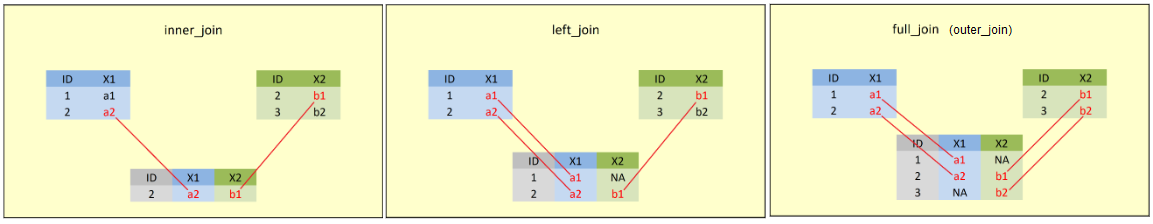


In [ ]:
# cruzamos ambos diccionarios y revisamos las especialidades sin match
# full join permite hacer el cruce de dos dataframes conservando los registros incompatibles de ambos
cruce <-
  especialidades %>%
  dplyr::full_join(especialidades_prog, by = c("Nombre" = "Nombre_prog"), keep = T) #by permite homologar las columnas "llave" de cada base que permiten unirlas

cruce

Codigo Nombre                                                            
1  07-001 ANATOMÍA PATOLÓGICA                                               
2  07-002 ANESTESIOLOGÍA                                                    
3  07-003 CARDIOLOGÍA                                                       
4  07-004 CIRUGÍA GENERAL                                                   
5  07-005 CIRUGÍA DE CABEZA, CUELLO Y MAXILOFACIAL                          
6  07-006 CIRUGÍA CARDIOVASCULAR                                            
7  07-007 CIRUGÍA DE TÓRAX                                                  
8  07-008 CIRUGÍA PLÁSTICA Y REPARADORA                                     
9  07-009 CIRUGÍA PEDIÁTRICA                                                
10 07-010 CIRUGÍA VASCULAR PERIFÉRICA                                       
11 07-011 COLOPROCTOLOGÍA                                                   
12 07-012 DERMATOLOGÍA                                                      
13 07-013 DIABETOLOGÍA                                                      
14 07-014 ENDOCRINOLOGÍA ADULTO                                             
15 07-015 ENDOCRINOLOGÍA PEDIÁTRICA                                         
16 07-016 ENFERMEDADES RESPIRATORIAS DEL ADULTO (BRONCOPULMONAR)            
17 07-017 ENFERMEDADES RESPIRATORIAS PEDIÁTRICAS (BRONCOPULMONAR PEDIATRICO)
18 07-018 GASTROENTEROLOGÍA ADULTO                                          
19 07-019 GASTROENTEROLOGÍA PEDIÁTRICA                                      
20 07-020 GENÉTICA CLÍNICA                                                  
21 07-021 GERIATRÍA                                                         
22 07-022 GINECOLOGÍA PEDIÁTRICA Y DE LA ADOLESCENCIA                       
23 07-023 HEMATOLOGÍA                                                       
24 07-024 IMAGENOLOGÍA                                                      
25 07-025 INFECTOLOGÍA                                                      
26 07-026 INMUNOLOGÍA                                                       
27 07-027 LABORATORIO CLÍNICO                                               
28 07-028 MEDICINA FAMILIAR                                                 
29 07-029 MEDICINA FÍSICA Y REHABILITACIÓN (FISIATRIA ADULTO)               
30 07-030 MEDICINA INTERNA                                                  
⋮  ⋮      ⋮                                                                 
64 07-064 NUTRIÓLOGO PEDIÁTRICO                                             
65 07-065 REUMATOLOGÍA PEDIÁTRICA                                           
66 07-066 OBSTETRICIA                                                       
67 07-067 TRAUMATOLOGÍA Y ORTOPEDIA PEDIÁTRICA                              
68 07-068 UROLOGÍA PEDIÁTRICA                                               
69 NA     NA                                                                
70 NA     NA                                                                
71 NA     NA                                                                
72 NA     NA                                                                
73 NA     NA                                                                
74 NA     NA                                                                
75 NA     NA                                                                
76 NA     NA                                                                
77 NA     NA                                                                
78 NA     NA                                                                
79 NA     NA                                                                
80 NA     NA                                                                
81 NA     NA                                                                
82 NA     NA                                                                
83 NA     NA                                                                

In [ ]:
# obtenemos las especialidades de programación que no coinciden
# observe que obtenemos los datos en formato array en vez de un dataframe
# Seleccionar los valores de Nombre_prog donde Nombre es NA
cruce$Nombre_prog[is.na(cruce$Nombre)]

#cruce['Nombre_prog'][cruce['Nombre'].isna()].array

[1] "CARDIOLOGÍA ADULTO"                                                
 [2] "CIRUGÍA DIGESTIVA (ALTA)"                                          
 [3] "CIRUGÍA GENERAL ADULTO"                                            
 [4] "CIRUGÍA PLÁSTICA Y REPARADORA ADULTO"                              
 [5] "CIRUGÍA PLÁSTICA Y REPARADORA PEDIÁTRICA"                          
 [6] "CIRUGÍA TÓRAX"                                                     
 [7] "COLOPROCTOLOGÍA (CIRUGIA DIGESTIVA BAJA)"                          
 [8] "ENFERMEDAD RESPIRATORIA DE ADULTO (BRONCOPULMONAR)"                
 [9] "ENFERMEDAD RESPIRATORIA PEDIÁTRICA (BRONCOPULMONAR INFANTIL)"      
[10] "GINECOLOGÍA ADULTO"                                                
[11] "HEMATOLOGÍA ADULTO"                                                
[12] "HEMATO-ONCOLOGÍA INFANTIL"                                         
[13] "INFECTOLOGÍA ADULTO"                                               
[14] "INFECTOLOGÍA PEDIÁTRICA"                                           
[15] "LABORATORIO CLINICO"                                               
[16] "MEDICINA FAMILIAR ADULTO"                                          
[17] "MEDICINA FÍSICA Y REHABILITACIÓN ADULTO (FISIATRÍA ADULTO)"        
[18] "MEDICINA FÍSICA Y REHABILITACIÓN PEDIÁTRICA (FISIATRÍA PEDIÁTRICA)"
[19] "MEDICINA INTENSIVA"                                                
[20] "MEDICINA NUCLEAR (EXCLUYE INFORMES)"                               
[21] "NEFROLOGÍA PEDIÁTRICA"                                             
[22] "NUTRIÓLOGO ADULTO"                                                 
[23] "REUMATOLOGÍA ADULTO"                                               
[24] "TRAUMATOLOGÍA Y ORTOPEDIA ADULTO"                                  
[25] "UROLOGÍA ADULTO"

In [ ]:
# obtenemos las especialidades 820 sin match
cruce$Nombre[is.na(cruce$Nombre_prog)]


[1] "CARDIOLOGÍA"                                                       
 [2] "CIRUGÍA GENERAL"                                                   
 [3] "CIRUGÍA DE TÓRAX"                                                  
 [4] "CIRUGÍA PLÁSTICA Y REPARADORA"                                     
 [5] "COLOPROCTOLOGÍA"                                                   
 [6] "ENFERMEDADES RESPIRATORIAS DEL ADULTO (BRONCOPULMONAR)"            
 [7] "ENFERMEDADES RESPIRATORIAS PEDIÁTRICAS (BRONCOPULMONAR PEDIATRICO)"
 [8] "HEMATOLOGÍA"                                                       
 [9] "INFECTOLOGÍA"                                                      
[10] "LABORATORIO CLÍNICO"                                               
[11] "MEDICINA FÍSICA Y REHABILITACIÓN (FISIATRIA ADULTO)"               
[12] "MEDICINA INTENSIVA ADULTO"                                         
[13] "MEDICINA INTENSIVA PEDIÁTRICA"                                     
[14] "MEDICINA LEGAL"                                                    
[15] "MEDICINA MATERNO INFANTIL"                                         
[16] "MEDICINA NUCLEAR"                                                  
[17] "NEFROLOGÍA PEDIÁTRICO"                                             
[18] "OBSTETRICIA Y GINECOLOGÍA"                                         
[19] "REUMATOLOGÍA"                                                      
[20] "SALUD PÚBLICA"                                                     
[21] "TRAUMATOLOGÍA Y ORTOPEDIA"                                         
[22] "UROLOGÍA"                                                          
[23] "CIRUGÍA DIGESTIVA"                                                 
[24] "CIRUGÍA PLASTICA Y REPARADORA PEDIÁTRICA"                          
[25] "GINECOLOGÍA"                                                       
[26] "HEMATO-ONCOLOGÍA PEDIÁTRICA"                                       
[27] "INFECTOLOGÍA PEDIATRICA"                                           
[28] "MEDICINA FISICA Y REHABILITACIÓN PEDIÁTRICA (FISIATRIA PEDIATRICA)"
[29] "NUTRIÓLOGO"

In [ ]:
# homologamos a la norma 820 las especialidades de programación sin match
# por ej., el original CARDIOLOGÍA ADULTO lo adaptamos a CARDIOLOGÍA
match_especialidad <- c(
  "CARDIOLOGÍA ADULTO" = "CARDIOLOGÍA",
  "CIRUGÍA DIGESTIVA (ALTA)" = "CIRUGÍA DIGESTIVA",
  "CIRUGÍA GENERAL ADULTO" = "CIRUGÍA GENERAL",
  "CIRUGÍA PLÁSTICA Y REPARADORA ADULTO" = "CIRUGÍA PLÁSTICA Y REPARADORA",
  "CIRUGÍA PLÁSTICA Y REPARADORA PEDIÁTRICA" = "CIRUGÍA PLASTICA Y REPARADORA PEDIÁTRICA",
  "CIRUGÍA TÓRAX" = "CIRUGÍA DE TÓRAX",
  "COLOPROCTOLOGÍA (CIRUGIA DIGESTIVA BAJA)" = "COLOPROCTOLOGÍA",
  "ENFERMEDAD RESPIRATORIA DE ADULTO (BRONCOPULMONAR)" = "ENFERMEDADES RESPIRATORIAS DEL ADULTO (BRONCOPULMONAR)",
  "ENFERMEDAD RESPIRATORIA PEDIÁTRICA (BRONCOPULMONAR INFANTIL)" = "ENFERMEDADES RESPIRATORIAS PEDIÁTRICAS (BRONCOPULMONAR PEDIATRICO)",
  "GINECOLOGÍA ADULTO" = "GINECOLOGÍA",
  "HEMATO-ONCOLOGÍA INFANTIL" = "HEMATO-ONCOLOGÍA PEDIÁTRICA",
  "HEMATOLOGÍA ADULTO" = "HEMATOLOGÍA",
  "INFECTOLOGÍA ADULTO" = "INFECTOLOGÍA",
  "INFECTOLOGÍA PEDIÁTRICA" = "INFECTOLOGÍA PEDIATRICA",
  "LABORATORIO CLINICO" = "LABORATORIO CLÍNICO",
  "MEDICINA FÍSICA Y REHABILITACIÓN ADULTO (FISIATRÍA ADULTO)" = "MEDICINA FÍSICA Y REHABILITACIÓN (FISIATRIA ADULTO)",
  "MEDICINA FÍSICA Y REHABILITACIÓN PEDIÁTRICA (FISIATRÍA PEDIÁTRICA)" = "MEDICINA FISICA Y REHABILITACIÓN PEDIÁTRICA (FISIATRIA PEDIATRICA)",
  "MEDICINA INTENSIVA" = "MEDICINA INTENSIVA ADULTO",
  "MEDICINA NUCLEAR (EXCLUYE INFORMES)" = "MEDICINA NUCLEAR",
  "NEFROLOGÍA PEDIÁTRICA" = "NEFROLOGÍA PEDIÁTRICO",
  "NUTRIÓLOGO ADULTO" = "NUTRIÓLOGO",
  "REUMATOLOGÍA ADULTO" = "REUMATOLOGÍA",
  "TRAUMATOLOGÍA Y ORTOPEDIA ADULTO" = "TRAUMATOLOGÍA Y ORTOPEDIA",
  "UROLOGÍA ADULTO" = "UROLOGÍA"
)

# creamos un campo con las especialidades de la programación homologadas a la norma 820
cruce <- cruce %>%
  dplyr::mutate(Nombre_fix = recode(
    Nombre_prog,
    !!!match_especialidad, # Desempaquetamos el diccionario
    .default = Nombre_prog # Mantener valores no mapeados
  ))

# Revisamos las especialidades de programación y su nombre original y el homologado
cruce %>%
  dplyr::select(Codigo_prog, Nombre_prog, Nombre_fix) %>%
  filter(if_all(everything(), ~ !is.na(.)))

Codigo_prog
1  7030997    
2  7023100    
3  7022144    
4  7021701    
5  7022130    
6  7022800    
7  7021300    
8  7024201    
9  7020600    
10 7020501    
11 7020700    
12 7020601    
13 7020800    
14 7021531    
15 7023201    
16 7030501    
17 7022001    
18 7024200    
19 7020230    
20 7030998    
21 7021000    
22 7020330    
23 7022900    
24 7021700    
25 7022134    
26 7023203    
27 7021800    
28 7023700    
29 7020130    
30 7021900    
⋮  ⋮          
35 7021001    
36 7021101    
37 7023200    
38 7023701    
39 7023703    
40 7020500    
41 7022143    
42 7022142    
43 7022136    
44 7022135    
45 7022700    
46 7022137    
47 7020332    
48 7020331    
49 7023202    
50 7020900    
51 7020801    
52 7022000    
53 7021301    
54 7030996    
55 7030500    
56 7022133    
57 7022132    
58 7030999    
59 7024202    
60 7020901    
61 7021100    
62 7021230    
63 7023702    
64 7024000    
   Nombre_prog                                                       
1  ANATOMÍA PATOLÓGICA                                               
2  ANESTESIOLOGÍA                                                    
3  CIRUGÍA DE CABEZA, CUELLO Y MAXILOFACIAL                          
4  CIRUGÍA CARDIOVASCULAR                                            
5  CIRUGÍA PEDIÁTRICA                                                
6  CIRUGÍA VASCULAR PERIFÉRICA                                       
7  DERMATOLOGÍA                                                      
8  DIABETOLOGÍA                                                      
9  ENDOCRINOLOGÍA ADULTO                                             
10 ENDOCRINOLOGÍA PEDIÁTRICA                                         
11 GASTROENTEROLOGÍA ADULTO                                          
12 GASTROENTEROLOGÍA PEDIÁTRICA                                      
13 GENÉTICA CLÍNICA                                                  
14 GERIATRÍA                                                         
15 GINECOLOGÍA PEDIÁTRICA Y DE LA ADOLESCENCIA                       
16 IMAGENOLOGÍA                                                      
17 INMUNOLOGÍA                                                       
18 MEDICINA FAMILIAR                                                 
19 MEDICINA INTERNA                                                  
20 MEDICINA DE URGENCIA                                              
21 NEFROLOGÍA ADULTO                                                 
22 NEONATOLOGÍA                                                      
23 NEUROCIRUGÍA                                                      
24 NEUROLOGÍA ADULTO                                                 
25 NEUROLOGÍA PEDIÁTRICA                                             
26 OFTALMOLOGÍA                                                      
27 ONCOLOGÍA MÉDICA                                                  
28 OTORRINOLARINGOLOGÍA                                              
29 PEDIATRÍA                                                         
30 PSIQUIATRÍA ADULTO                                                
⋮  ⋮                                                                 
35 NUTRIÓLOGO PEDIÁTRICO                                             
36 REUMATOLOGÍA PEDIÁTRICA                                           
37 OBSTETRICIA                                                       
38 TRAUMATOLOGÍA Y ORTOPEDIA PEDIÁTRICA                              
39 UROLOGÍA PEDIÁTRICA                                               
40 CARDIOLOGÍA ADULTO                                                
41 CIRUGÍA DIGESTIVA (ALTA)                                          
42 CIRUGÍA GENERAL ADULTO                                            
43 CIRUGÍA PLÁSTICA Y REPARADORA ADULTO                              
44 CIRUGÍA PLÁSTICA Y REPARADORA PEDIÁTRICA                          
45 CIRUGÍA TÓRAX                                                     
46 COLOPROCTOLOGÍA (CIRUGIA DIGESTIVA BAJA)                    

In [ ]:
# Agregamos el código de las especialidades de programación al maestro
# para ello cruzamos el maestro con las especialidades de programación homologadas
especialidades <- especialidades %>%
  dplyr::left_join( #unimos dejando especialidades como la base maestra (se conserva como está especialidades y sólo se agregan aquellos casos de la base cruce que coinciden con la llave de especialidades)
    na.omit( dplyr::select(cruce, Codigo_prog, Nombre_prog, Nombre_fix) ), #de la base cruce, seleccionamos las 3 columnas de interés, y luego omitimos los perdidos de todas las columnas
    by = c("Nombre" = "Nombre_fix"),  #con qué llaves se unen
    keep= T #conservar ambas lalves
  )
especialidades

Codigo Nombre                                                            
1  07-001 ANATOMÍA PATOLÓGICA                                               
2  07-002 ANESTESIOLOGÍA                                                    
3  07-003 CARDIOLOGÍA                                                       
4  07-004 CIRUGÍA GENERAL                                                   
5  07-005 CIRUGÍA DE CABEZA, CUELLO Y MAXILOFACIAL                          
6  07-006 CIRUGÍA CARDIOVASCULAR                                            
7  07-007 CIRUGÍA DE TÓRAX                                                  
8  07-008 CIRUGÍA PLÁSTICA Y REPARADORA                                     
9  07-009 CIRUGÍA PEDIÁTRICA                                                
10 07-010 CIRUGÍA VASCULAR PERIFÉRICA                                       
11 07-011 COLOPROCTOLOGÍA                                                   
12 07-012 DERMATOLOGÍA                                                      
13 07-013 DIABETOLOGÍA                                                      
14 07-014 ENDOCRINOLOGÍA ADULTO                                             
15 07-015 ENDOCRINOLOGÍA PEDIÁTRICA                                         
16 07-016 ENFERMEDADES RESPIRATORIAS DEL ADULTO (BRONCOPULMONAR)            
17 07-017 ENFERMEDADES RESPIRATORIAS PEDIÁTRICAS (BRONCOPULMONAR PEDIATRICO)
18 07-018 GASTROENTEROLOGÍA ADULTO                                          
19 07-019 GASTROENTEROLOGÍA PEDIÁTRICA                                      
20 07-020 GENÉTICA CLÍNICA                                                  
21 07-021 GERIATRÍA                                                         
22 07-022 GINECOLOGÍA PEDIÁTRICA Y DE LA ADOLESCENCIA                       
23 07-023 HEMATOLOGÍA                                                       
24 07-024 IMAGENOLOGÍA                                                      
25 07-025 INFECTOLOGÍA                                                      
26 07-026 INMUNOLOGÍA                                                       
27 07-027 LABORATORIO CLÍNICO                                               
28 07-028 MEDICINA FAMILIAR                                                 
29 07-029 MEDICINA FÍSICA Y REHABILITACIÓN (FISIATRIA ADULTO)               
30 07-030 MEDICINA INTERNA                                                  
⋮  ⋮      ⋮                                                                 
39 07-039 NEONATOLOGÍA                                                      
40 07-040 NEUROCIRUGÍA                                                      
41 07-041 NEUROLOGÍA ADULTO                                                 
42 07-042 NEUROLOGÍA PEDIÁTRICA                                             
43 07-043 OBSTETRICIA Y GINECOLOGÍA                                         
44 07-044 OFTALMOLOGÍA                                                      
45 07-045 ONCOLOGÍA MÉDICA                                                  
46 07-046 OTORRINOLARINGOLOGÍA                                              
47 07-047 PEDIATRÍA                                                         
48 07-048 PSIQUIATRÍA ADULTO                                                
49 07-049 PSIQUIATRÍA PEDIÁTRICA Y DE LA ADOLESCENCIA                       
50 07-050 RADIOTERAPIA ONCOLÓGICA                                           
51 07-051 REUMATOLOGÍA                                                      
52 07-052 SALUD PÚBLICA                                                     
53 07-053 TRAUMATOLOGÍA Y ORTOPEDIA                                         
54 07-054 UROLOGÍA                                                          
55 07-055 CARDIOLOGÍA PEDIÁTRICA                                            
56 07-056 CIRUGÍA DIGESTIVA                                                 
57 07-057 CIRUGÍA PLASTICA Y REPARADORA PEDIÁTRICA                          
58 07-058 GINECOLOGÍA                                                       

In [ ]:
# Eliminamos el campo que utilizamos para homologar ambos diccionarios
especialidades$Nombre_fix <- NULL

# Vemos el diccionario especialidades para nuestro análisis
especialidades

Codigo Nombre                                                            
1  07-001 ANATOMÍA PATOLÓGICA                                               
2  07-002 ANESTESIOLOGÍA                                                    
3  07-003 CARDIOLOGÍA                                                       
4  07-004 CIRUGÍA GENERAL                                                   
5  07-005 CIRUGÍA DE CABEZA, CUELLO Y MAXILOFACIAL                          
6  07-006 CIRUGÍA CARDIOVASCULAR                                            
7  07-007 CIRUGÍA DE TÓRAX                                                  
8  07-008 CIRUGÍA PLÁSTICA Y REPARADORA                                     
9  07-009 CIRUGÍA PEDIÁTRICA                                                
10 07-010 CIRUGÍA VASCULAR PERIFÉRICA                                       
11 07-011 COLOPROCTOLOGÍA                                                   
12 07-012 DERMATOLOGÍA                                                      
13 07-013 DIABETOLOGÍA                                                      
14 07-014 ENDOCRINOLOGÍA ADULTO                                             
15 07-015 ENDOCRINOLOGÍA PEDIÁTRICA                                         
16 07-016 ENFERMEDADES RESPIRATORIAS DEL ADULTO (BRONCOPULMONAR)            
17 07-017 ENFERMEDADES RESPIRATORIAS PEDIÁTRICAS (BRONCOPULMONAR PEDIATRICO)
18 07-018 GASTROENTEROLOGÍA ADULTO                                          
19 07-019 GASTROENTEROLOGÍA PEDIÁTRICA                                      
20 07-020 GENÉTICA CLÍNICA                                                  
21 07-021 GERIATRÍA                                                         
22 07-022 GINECOLOGÍA PEDIÁTRICA Y DE LA ADOLESCENCIA                       
23 07-023 HEMATOLOGÍA                                                       
24 07-024 IMAGENOLOGÍA                                                      
25 07-025 INFECTOLOGÍA                                                      
26 07-026 INMUNOLOGÍA                                                       
27 07-027 LABORATORIO CLÍNICO                                               
28 07-028 MEDICINA FAMILIAR                                                 
29 07-029 MEDICINA FÍSICA Y REHABILITACIÓN (FISIATRIA ADULTO)               
30 07-030 MEDICINA INTERNA                                                  
⋮  ⋮      ⋮                                                                 
39 07-039 NEONATOLOGÍA                                                      
40 07-040 NEUROCIRUGÍA                                                      
41 07-041 NEUROLOGÍA ADULTO                                                 
42 07-042 NEUROLOGÍA PEDIÁTRICA                                             
43 07-043 OBSTETRICIA Y GINECOLOGÍA                                         
44 07-044 OFTALMOLOGÍA                                                      
45 07-045 ONCOLOGÍA MÉDICA                                                  
46 07-046 OTORRINOLARINGOLOGÍA                                              
47 07-047 PEDIATRÍA                                                         
48 07-048 PSIQUIATRÍA ADULTO                                                
49 07-049 PSIQUIATRÍA PEDIÁTRICA Y DE LA ADOLESCENCIA                       
50 07-050 RADIOTERAPIA ONCOLÓGICA                                           
51 07-051 REUMATOLOGÍA                                                      
52 07-052 SALUD PÚBLICA                                                     
53 07-053 TRAUMATOLOGÍA Y ORTOPEDIA                                         
54 07-054 UROLOGÍA                                                          
55 07-055 CARDIOLOGÍA PEDIÁTRICA                                            
56 07-056 CIRUGÍA DIGESTIVA                                                 
57 07-057 CIRUGÍA PLASTICA Y REPARADORA PEDIÁTRICA                          
58 07-058 GINECOLOGÍA                                                       

### 🏁 Discusión

1. ¿Cuántas especialidades existen en nuestra base de datos?
2. ¿Qué atributos tiene cada especialidad? ¿Cuál es el identificador (llave primaria)?
1. ¿Cuántas especialidades se programan en nuestra base de datos?

## Agregar especialidades REM

In [ ]:
# Obtenemos los códigos de las prestaciones del REM de consultas de especialidad
especialidades_rem <- produccion %>%
  dplyr::select(CodigoPrestacion) %>%  # Seleccionamos la columna CodigoPrestacion
  dplyr::distinct() %>%                # Eliminamos duplicados
  dplyr::rename(Codigo_rem = CodigoPrestacion)  # Cambiamos el nombre de la columna

# Ver el resultado
especialidades_rem

Codigo_rem
1  7022133   
2  7022134   
3  7021700   
4  7021800   
5  7024200   
6  7030500   
7  7023701   
8  7023702   
9  7024000   
10 7024201   
11 7020700   
12 7020800   
13 7020801   
14 7020900   
15 7020901   
16 7021000   
17 7021001   
18 7021100   
19 7021101   
20 7021230   
21 7021300   
22 7021301   
23 7022900   
24 7021701   
25 7023100   
26 7023200   
27 7023201   
28 7023202   
29 7023203   
30 7023700   
31 7022137   
32 7022700   
33 7021801   
34 7021900   
35 7022130   
36 7022142   
37 7022143   
38 7022144   
39 7022135   
40 7022136   
41 7023703   
42 7022000   
43 7022132   
44 7022800   
45 7024001   
46 7020130   
47 7020230   
48 7020331   
49 7020332   
50 7022001   
51 7021531   
52 7024219   
53 7020500   
54 7020501   
55 7020600   
56 7020601   
57 7020330

In [ ]:
# Cruzamos las especialidades REM con las especialidades de programación del diccionario
cruce_rem <-
  especialidades %>%
  #cambiamos la clase de la variable para que coincida con la de la base de datos "especialidades_rem"
  #ℹ `x$Codigo_prog` is a <character>.
  #ℹ `y$Codigo_rem` is a <double>.
    dplyr::mutate(Codigo_prog= as.numeric(Codigo_prog))%>%
  dplyr::full_join(especialidades_rem, by = c("Codigo_prog" = "Codigo_rem"), keep = T) #by permite homologar las columnas "llave" de cada base que permiten unirlas

# Vemos el resultado
cruce_rem

Codigo Nombre                                                            
1  07-001 ANATOMÍA PATOLÓGICA                                               
2  07-002 ANESTESIOLOGÍA                                                    
3  07-003 CARDIOLOGÍA                                                       
4  07-004 CIRUGÍA GENERAL                                                   
5  07-005 CIRUGÍA DE CABEZA, CUELLO Y MAXILOFACIAL                          
6  07-006 CIRUGÍA CARDIOVASCULAR                                            
7  07-007 CIRUGÍA DE TÓRAX                                                  
8  07-008 CIRUGÍA PLÁSTICA Y REPARADORA                                     
9  07-009 CIRUGÍA PEDIÁTRICA                                                
10 07-010 CIRUGÍA VASCULAR PERIFÉRICA                                       
11 07-011 COLOPROCTOLOGÍA                                                   
12 07-012 DERMATOLOGÍA                                                      
13 07-013 DIABETOLOGÍA                                                      
14 07-014 ENDOCRINOLOGÍA ADULTO                                             
15 07-015 ENDOCRINOLOGÍA PEDIÁTRICA                                         
16 07-016 ENFERMEDADES RESPIRATORIAS DEL ADULTO (BRONCOPULMONAR)            
17 07-017 ENFERMEDADES RESPIRATORIAS PEDIÁTRICAS (BRONCOPULMONAR PEDIATRICO)
18 07-018 GASTROENTEROLOGÍA ADULTO                                          
19 07-019 GASTROENTEROLOGÍA PEDIÁTRICA                                      
20 07-020 GENÉTICA CLÍNICA                                                  
21 07-021 GERIATRÍA                                                         
22 07-022 GINECOLOGÍA PEDIÁTRICA Y DE LA ADOLESCENCIA                       
23 07-023 HEMATOLOGÍA                                                       
24 07-024 IMAGENOLOGÍA                                                      
25 07-025 INFECTOLOGÍA                                                      
26 07-026 INMUNOLOGÍA                                                       
27 07-027 LABORATORIO CLÍNICO                                               
28 07-028 MEDICINA FAMILIAR                                                 
29 07-029 MEDICINA FÍSICA Y REHABILITACIÓN (FISIATRIA ADULTO)               
30 07-030 MEDICINA INTERNA                                                  
⋮  ⋮      ⋮                                                                 
40 07-040 NEUROCIRUGÍA                                                      
41 07-041 NEUROLOGÍA ADULTO                                                 
42 07-042 NEUROLOGÍA PEDIÁTRICA                                             
43 07-043 OBSTETRICIA Y GINECOLOGÍA                                         
44 07-044 OFTALMOLOGÍA                                                      
45 07-045 ONCOLOGÍA MÉDICA                                                  
46 07-046 OTORRINOLARINGOLOGÍA                                              
47 07-047 PEDIATRÍA                                                         
48 07-048 PSIQUIATRÍA ADULTO                                                
49 07-049 PSIQUIATRÍA PEDIÁTRICA Y DE LA ADOLESCENCIA                       
50 07-050 RADIOTERAPIA ONCOLÓGICA                                           
51 07-051 REUMATOLOGÍA                                                      
52 07-052 SALUD PÚBLICA                                                     
53 07-053 TRAUMATOLOGÍA Y ORTOPEDIA                                         
54 07-054 UROLOGÍA                                                          
55 07-055 CARDIOLOGÍA PEDIÁTRICA                                            
56 07-056 CIRUGÍA DIGESTIVA                                                 
57 07-057 CIRUGÍA PLASTICA Y REPARADORA PEDIÁTRICA                          
58 07-058 GINECOLOGÍA                                                       
59 07-059 HEMATO-ONCOLOGÍA PEDIÁTRICA                                       

In [ ]:
# ¿Qué prestaciones REM no son homologables al maestro de especialidades?
cruce_rem[is.na(cruce_rem$Codigo), ]

Codigo Nombre Codigo_prog Nombre_prog Codigo_rem
69 NA     NA     NA          NA          7030500

In [ ]:
# Note que radioterapia oncológica si está en el diccionario, ¡pero con otro código!
especialidades[which(especialidades$Nombre_prog=='RADIOTERAPIA ONCOLÓGICA'),] #buscamos en la base de datos, la fila (por eso los argumentos van a la izquierda de la coma dentro de las llaves [XXXXXX,]), en que el vector Nombre_prog de la base especialidades coincide con 'RADIOTERAPIA ONCOLÓGICA'

Codigo Nombre                  Codigo_prog Nombre_prog            
50 07-050 RADIOTERAPIA ONCOLÓGICA 7030502     RADIOTERAPIA ONCOLÓGICA

In [ ]:
# Corregimos manualmente el Codigo REM de radioterapia oncológica en el cruce_rem
cruce_rem$Codigo_rem[cruce_rem$Nombre_prog == "RADIOTERAPIA ONCOLÓGICA"] <- 7030500 # para la columna Codigo_rem, tomamos los elementos cuyos valores de Nombre_prog coinciden con  "RADIOTERAPIA ONCOLÓGICA" y los reemplazamos con el código 7030500

# Vemos el resultado
cruce_rem[cruce_rem$Nombre_prog == "RADIOTERAPIA ONCOLÓGICA", ] #ahora vemos las filas de la base de datos cruce_rem en que la columna Nombre_prog coincide con "RADIOTERAPIA ONCOLÓGICA"

Codigo Nombre                  Codigo_prog Nombre_prog            
NA   NA     NA                           NA     NA                     
NA.1 NA     NA                           NA     NA                     
NA.2 NA     NA                           NA     NA                     
NA.3 NA     NA                           NA     NA                     
50   07-050 RADIOTERAPIA ONCOLÓGICA 7030502     RADIOTERAPIA ONCOLÓGICA
NA.4 NA     NA                           NA     NA                     
NA.5 NA     NA                           NA     NA                     
     Codigo_rem
NA        NA   
NA.1      NA   
NA.2      NA   
NA.3      NA   
50   7030500   
NA.4      NA   
NA.5      NA

In [ ]:
# Agregamos el código REM al maestro de especialidades
especialidades <- especialidades %>%
  dplyr::left_join(na.omit(cruce_rem[, c("Codigo", "Codigo_rem")]), #de la base cruce_rem, de la que también seleccionamos las columnas "Codigo" y "Codigo_rem", eliminamos todas las observaciones (filas) que contengan al menos un NA
            by = "Codigo") #unimos las bases por una llave común llamada Codigo

# Vemos el resultado
especialidades

Codigo Nombre                                                            
1  07-001 ANATOMÍA PATOLÓGICA                                               
2  07-002 ANESTESIOLOGÍA                                                    
3  07-003 CARDIOLOGÍA                                                       
4  07-004 CIRUGÍA GENERAL                                                   
5  07-005 CIRUGÍA DE CABEZA, CUELLO Y MAXILOFACIAL                          
6  07-006 CIRUGÍA CARDIOVASCULAR                                            
7  07-007 CIRUGÍA DE TÓRAX                                                  
8  07-008 CIRUGÍA PLÁSTICA Y REPARADORA                                     
9  07-009 CIRUGÍA PEDIÁTRICA                                                
10 07-010 CIRUGÍA VASCULAR PERIFÉRICA                                       
11 07-011 COLOPROCTOLOGÍA                                                   
12 07-012 DERMATOLOGÍA                                                      
13 07-013 DIABETOLOGÍA                                                      
14 07-014 ENDOCRINOLOGÍA ADULTO                                             
15 07-015 ENDOCRINOLOGÍA PEDIÁTRICA                                         
16 07-016 ENFERMEDADES RESPIRATORIAS DEL ADULTO (BRONCOPULMONAR)            
17 07-017 ENFERMEDADES RESPIRATORIAS PEDIÁTRICAS (BRONCOPULMONAR PEDIATRICO)
18 07-018 GASTROENTEROLOGÍA ADULTO                                          
19 07-019 GASTROENTEROLOGÍA PEDIÁTRICA                                      
20 07-020 GENÉTICA CLÍNICA                                                  
21 07-021 GERIATRÍA                                                         
22 07-022 GINECOLOGÍA PEDIÁTRICA Y DE LA ADOLESCENCIA                       
23 07-023 HEMATOLOGÍA                                                       
24 07-024 IMAGENOLOGÍA                                                      
25 07-025 INFECTOLOGÍA                                                      
26 07-026 INMUNOLOGÍA                                                       
27 07-027 LABORATORIO CLÍNICO                                               
28 07-028 MEDICINA FAMILIAR                                                 
29 07-029 MEDICINA FÍSICA Y REHABILITACIÓN (FISIATRIA ADULTO)               
30 07-030 MEDICINA INTERNA                                                  
⋮  ⋮      ⋮                                                                 
39 07-039 NEONATOLOGÍA                                                      
40 07-040 NEUROCIRUGÍA                                                      
41 07-041 NEUROLOGÍA ADULTO                                                 
42 07-042 NEUROLOGÍA PEDIÁTRICA                                             
43 07-043 OBSTETRICIA Y GINECOLOGÍA                                         
44 07-044 OFTALMOLOGÍA                                                      
45 07-045 ONCOLOGÍA MÉDICA                                                  
46 07-046 OTORRINOLARINGOLOGÍA                                              
47 07-047 PEDIATRÍA                                                         
48 07-048 PSIQUIATRÍA ADULTO                                                
49 07-049 PSIQUIATRÍA PEDIÁTRICA Y DE LA ADOLESCENCIA                       
50 07-050 RADIOTERAPIA ONCOLÓGICA                                           
51 07-051 REUMATOLOGÍA                                                      
52 07-052 SALUD PÚBLICA                                                     
53 07-053 TRAUMATOLOGÍA Y ORTOPEDIA                                         
54 07-054 UROLOGÍA                                                          
55 07-055 CARDIOLOGÍA PEDIÁTRICA                                            
56 07-056 CIRUGÍA DIGESTIVA                                                 
57 07-057 CIRUGÍA PLASTICA Y REPARADORA PEDIÁTRICA                          
58 07-058 GINECOLOGÍA                                                       

In [ ]:
# Agregamos el diccionario a la base de datos normalizados
especialidades %>%
  rio::export(paste0(datos_normalizados, 'Especialidades.xlsx'), rowNames = FALSE)

### 🏁 Discusión

1. ¿Cuántas especialidades existen en nuestra base de datos?
2. ¿Qué atributos tiene cada especialidad? ¿Cuál es el identificador (llave primaria)?
3. ¿Qué significa que una especialidad del diccionario no tenga código REM o de programación? ¿Es una inconsistencia?
2. ¿Qué pasa si una especialidad no tiene código norma 820? ¿Es una inconsistencia?

# 🍎 Desafío 1: Normalizar Producción

1. Obtenga los datos REM (```rem_A07_2021_SSMSO.parquet```) de la carpeta de *datos_crudos* y examine la información que contiene
2. Genere un dataframe con las columnas:
  - Año
  - Mes
  - IdEstablecimiento
  - CodigoPrestacion
  - ConsultasTotales (utilice los datos de `Col1`)
  - ConsultasNuevas (utilice `Col22 + Col26`)
  - Controles (`ConsultasTotales - ConsultasNuevas`)
3. Codifique las prestaciones con la norma 820. Para ello:
  - Cambie el nombre de *CodigoPrestacion* por *Codigo_rem*
  - Agrege el campo *Especialidad* de la tabla *Especialidades* con un *Join* en base al campo *Codigo_rem*
  - Elimine el campo *Codigo_rem*
4. Guarde el dataframe resultante en la carpeta *datos_normalizados*

# 🍎 Desafío 2: Normalizar Programación